In [1]:
import sys
import os
sys.path.insert(0,'..')
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.init as init
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from maxpool import *
from relu import *
from models import *
from data_utils import *
%matplotlib inline

In [2]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    cudnn.benchmark = False
    # Deterministic convolutions
    torch.backends.cudnn.deterministic = True

In [3]:
maxpool_native = lambda: MaxPool2DBeta(0)
maxpool_custom = lambda: MaxPool2DBeta(1)
relu_0 = lambda:ReLUAlpha(0)
relu_1 = lambda:ReLUAlpha(1)

def init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal_(m.weight, 0, 0.01)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

            
def build_models(network, precision, batchnorm):
    if batchnorm : 
        net1 = VGG(network, batch_norm=True, maxpool_fn=maxpool_native, relu_fn=relu_0)
        net2 = VGG(network, batch_norm=True, maxpool_fn=maxpool_custom, relu_fn=relu_0)
    else : 
        net1 = VGG(network, maxpool_fn=maxpool_native, relu_fn=relu_0)
        net2 = VGG(network, maxpool_fn=maxpool_custom, relu_fn=relu_0)
        
    init_weights(net1)
    net2.load_state_dict(net1.state_dict())
    for net in [net1, net2]:
        net.to(device)
        if precision == 16:
            net.half()
        if precision == 64:
            net.double()
    return net1, net2

def rebuild_model(net1, net2):
    net1.apply(init_weights)
    net2.load_state_dict(net1.state_dict())

def compute_norms(net1, net2):
    diff = 0
    for p1, p2 in zip(net1.parameters(), net2.parameters()):
        diff += torch.norm(p1.grad - p2.grad, float('+inf'))
    return diff.item()

In [4]:
batch_size = 128

transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
traindata = datasets.CIFAR10(root=data_dir, train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size)

### Volume by precision

In [5]:
nb_experiments = 1
df = pd.DataFrame(columns=["precision", "count", "iteration"])
for precision in tqdm([16,32,64], desc='precision'):
    if precision == 64 :
        nb_experiments = 1
        threshold = 1e-15
    if precision == 32 :
        threshold = 1e-7
    if precision == 16 :
        threshold = 1e-3
    count = 0
    iteration = 0
    (net1, net2) = build_models('VGG11', precision, False)
    opt = optim.SGD([{'params': net1.parameters()}, {'params': net2.parameters()}], lr=0)
    for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
        rebuild_model(net1, net2)
        for x, y in trainloader:
            opt.zero_grad()
            x = x.to(device) # + torch.randn(x.size()).to(device)
            if precision == 16:
                x = x.half()
            if precision == 64:
                x = x.double()
            y = y.to(device)
            y1, y2 = net1(x), net2(x)
            loss = nn.CrossEntropyLoss()(y1, y) + nn.CrossEntropyLoss()(y2, y)
            loss.backward()
            norm = compute_norms(net1, net2)
            if norm > threshold:
                count += 1
            iteration += 1
    df = df.append({"precision": precision,
                        "count": count,
                        "iteration": iteration}, ignore_index=True)
    
df['ratio'] = 100*df['count'] / df['iteration']

precision:   0%|          | 0/3 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
df

,precision,count,iteration,ratio
0,16,391,391,100
1,32,216,391,55.243
2,64,0,391,0


In [7]:
nb_experiments = 1
df = pd.DataFrame(columns=["precision", "count"])
for precision in tqdm([16,32,64], desc='precision'):
    if precision == 64 :
        nb_experiments = 1
        threshold = 1e-15
    if precision == 32 :
        threshold = 1e-6
    if precision == 16 :
        threshold = 1e-3
    count = 0
    for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
        (net1, net2) = build_models('VGG11', precision, False)
        opt = optim.SGD([{'params': net1.parameters()}, {'params': net2.parameters()}], lr=0)
        for x, y in trainloader:
            opt.zero_grad()
            x = x.to(device) # + torch.randn(x.size()).to(device)
            if precision == 16:
                x = x.half()
            if precision == 64:
                x = x.double()
            y = y.to(device)
            y1, y2 = net1(x), net2(x)
            loss = nn.CrossEntropyLoss()(y1, y) + nn.CrossEntropyLoss()(y2, y)
            loss.backward()
            norm = compute_norms(net1, net2)
            if norm > threshold:
                print(norm)
                count += 1
                break
    df = df.append({"precision": precision,
                    "count": count}, ignore_index=True)
    
df['ratio'] = df['count'] / nb_experiments

precision:   0%|          | 0/3 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

0.001895904541015625


run:   0%|          | 0/1 [00:00<?, ?it/s]

1.4835968613624573e-06


run:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
df

,precision,count,ratio
0,16,1,1
1,32,1,1
2,64,0,0


### Volume by network size

In [17]:
nb_experiments = 1
df1 = pd.DataFrame(columns=["precision", "count", "network", "iteration"])
for precision in tqdm([16,32,64], desc='precision'):
    if precision == 64 :
        nb_experiments = 1
        threshold = 1e-15
    if precision == 32 :
        threshold = 1e-7
    if precision == 16 :
        threshold = 1e-3
    for network in tqdm(["VGG11","VGG13","VGG16","VGG19"], desc='VGG_type', leave=False):
        count = 0
        iteration = 0
        (net1, net2) = build_models(network, precision, False)
        opt = optim.SGD([{'params': net1.parameters()}, {'params': net2.parameters()}], lr=0)
        for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
            rebuild_model(net1, net2)
            for x, y in trainloader:
                opt.zero_grad()
                x = x.to(device) # + torch.randn(x.size()).to(device)
                if precision == 16:
                    x = x.half()
                if precision == 64:
                    x = x.double()
                y = y.to(device)
                y1, y2 = net1(x), net2(x)
                loss = nn.CrossEntropyLoss()(y1, y) + nn.CrossEntropyLoss()(y2, y)
                loss.backward()
                norm = compute_norms(net1, net2)
                if norm > threshold:
                    count += 1
                iteration += 1
        df1 = df1.append({"precision": precision,
                        "network": network,
                        "count": count,
                        "iteration": iteration}, ignore_index=True)

df1['ratio'] = 100*df1['count'] / df1['iteration']

precision:   0%|          | 0/3 [00:00<?, ?it/s]

VGG_type:   0%|          | 0/4 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

VGG_type:   0%|          | 0/4 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

VGG_type:   0%|          | 0/4 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

### Volume by batch size

In [ ]:
nb_experiments = 1
df2 = pd.DataFrame(columns=["precision", "count", "batch_size","iteration"])
for precision in tqdm([16,32,64], desc='precision'):
    if precision == 64 :
        threshold = 1e-15
        nb_experiments = 1
    if precision == 32 :
        threshold = 1e-7
    if precision == 16 :
        threshold = 1e-3
    for batch_size in tqdm([64, 256, 512, 1024], desc='batch_size', leave=False):
        trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size)
        count = 0
        iteration = 0
        (net1, net2) = build_models(network, precision, False)
        opt = optim.SGD([{'params': net1.parameters()}, {'params': net2.parameters()}], lr=0)
        for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
            rebuild_model(net1, net2) 
            for x, y in trainloader:
                opt.zero_grad()
                x = x.to(device)
                if precision == 16:
                    x = x.half()
                if precision == 64:
                    x = x.double()
                y = y.to(device)
                y1 = net1(x)
                y2 = net2(x)
                l1 = nn.CrossEntropyLoss()(y1, y)
                l2 = nn.CrossEntropyLoss()(y2, y)
                l1.backward(), l2.backward()
                norm = compute_norms(net1, net2)
                if norm > threshold:
                    count += 1
                iteration += 1
        df2 = df2.append({"precision": precision,
                        "batch_size": batch_size,
                        "count": count ,
                        "iteration": iteration}, ignore_index=True)
        
df2['ratio'] = 100*df2['count'] / df2['iteration']

precision:   0%|          | 0/3 [00:00<?, ?it/s]

batch_size:   0%|          | 0/4 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

batch_size:   0%|          | 0/4 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

batch_size:   0%|          | 0/4 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

### Volume by batch norm

In [11]:
nb_experiments = 1
trainloader = torch.utils.data.DataLoader(traindata, batch_size=128)
df3 = pd.DataFrame(columns=["precision", "count", "batchnorm","iteration"])
for precision in tqdm([16,32,64], desc='precision'):
    if precision == 64 :
        threshold = 1e-15
        nb_experiments = 1
    if precision == 32 :
        threshold = 1e-7
    if precision == 16 :
        threshold = 1e-3
    for batchnorm in tqdm([True,False], desc='batchnorm', leave=False):
        count = 0
        iteration = 0
        (net1, net2) = build_models('VGG11', precision, batchnorm)
        opt = optim.SGD([{'params': net1.parameters()}, {'params': net2.parameters()}], lr=0)
        for run_id in tqdm(range(nb_experiments), desc='run', leave=False):
            rebuild_model(net1, net2) 
            for x, y in trainloader:
                opt.zero_grad()
                x = x.to(device)
                if precision == 16:
                    x = x.half()
                if precision == 64:
                    x = x.double()
                y = y.to(device)
                y1 = net1(x)
                y2 = net2(x)
                l1 = nn.CrossEntropyLoss()(y1, y)
                l2 = nn.CrossEntropyLoss()(y2, y)
                l1.backward(), l2.backward()
                norm = compute_norms(net1, net2)
                if norm > threshold:
                    count += 1
                iteration += 1
        df3 = df3.append({"precision": precision,
                        "batchnorm": batchnorm,
                        "count": count ,
                        "iteration": iteration}, ignore_index=True)
        
df3['ratio'] = 100*df3['count'] / df3['iteration']

run:   0%|          | 0/1 [00:00<?, ?it/s]

batchnorm:   0%|          | 0/2 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

batchnorm:   0%|          | 0/2 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

run:   0%|          | 0/1 [00:00<?, ?it/s]

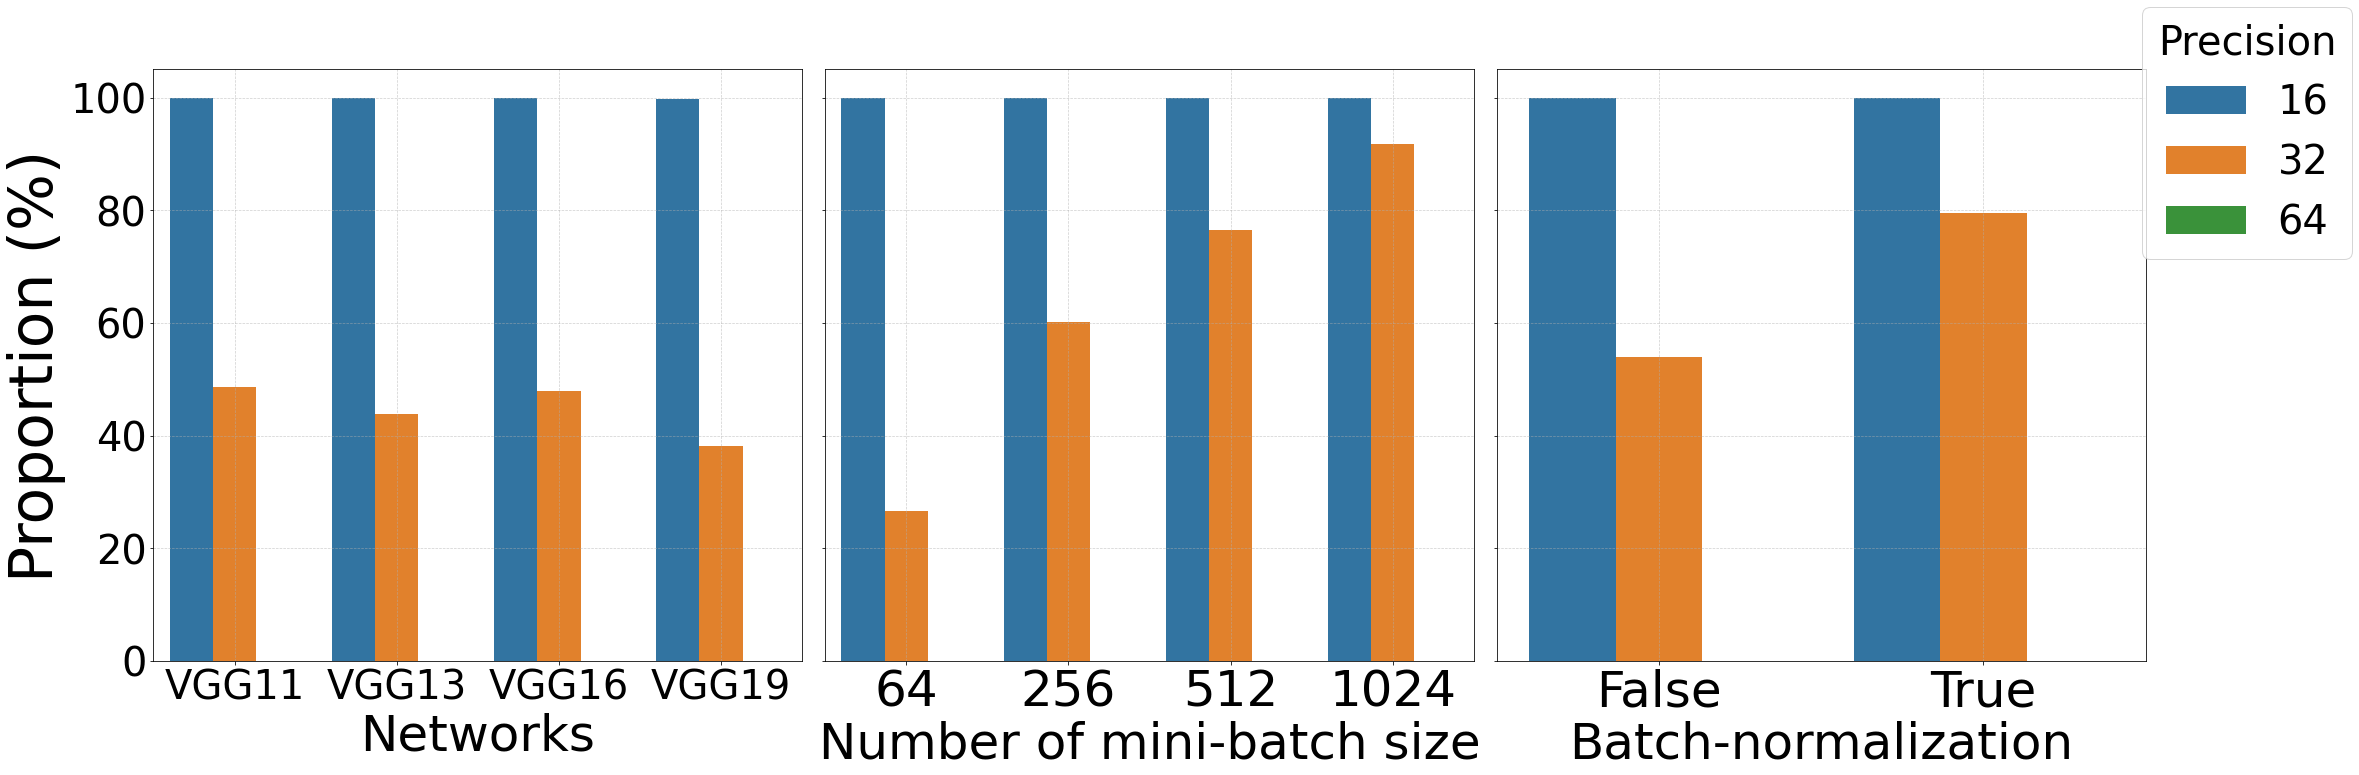

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 10), sharey=True)

# First plot
sns.barplot(x="network", y="ratio", hue="precision", data=df1, ax=axes[0])
axes[0].set_xlabel('Networks', fontsize=50)
axes[0].set_ylabel('Proportion (%)', fontsize=60)
axes[0].tick_params(axis='both', labelsize=40)
axes[0].grid(True, linestyle='--', alpha=0.6, linewidth=0.7)
axes[0].get_legend().remove()

# Second plot
sns.barplot(x="batch_size", y="ratio", hue="precision", data=df2, ax=axes[1])
axes[1].set_xlabel('Number of mini-batch size', fontsize=50)
axes[1].set_ylabel('')
axes[1].tick_params(axis='both', labelsize=50)
axes[1].grid(True, linestyle='--', alpha=0.6, linewidth=0.7)
axes[1].get_legend().remove()

# Third plot
sns.barplot(x="batchnorm", y="ratio", hue="precision", data=df3, ax=axes[2])
axes[2].set_xlabel('Batch-normalization', fontsize=50)
axes[2].set_ylabel('')
axes[2].tick_params(axis='both', labelsize=50)
axes[2].grid(True, linestyle='--', alpha=0.6, linewidth=0.7)
axes[2].get_legend().remove()

# Create an overall legend in the figure
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Precision', fontsize=40, title_fontsize=40, bbox_to_anchor=(1.1, 1.1))

plt.tight_layout()
plt.savefig('figures/impactfactors.pdf', bbox_inches='tight')
plt.show()
